In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns

from nnaps import predictors
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


In [ ]:
#df_raw = pd.read_csv('data/sdBShortP_training_set.csv')
# df_raw = pd.read_csv('data/sdBShortP_large_BPS_training_set.csv')
df_raw = pd.read_csv('/home/joris/MESA/mesa-models/BPS_grid_large/sdBShortP_large_Mdot0_alpha_0.5.csv')
# df_raw = pd.read_csv('/home/joris/MESA/mesa-models/BPS_grid_large/sdBShortP_large_Mdot-1_alpha_0.5.csv')

In [ ]:
ce_index = df_raw[df_raw['stability'] == 'CE'].index
df_ce = df_raw[df_raw['stability'] == 'CE']

In [ ]:
df_ce['product'].value_counts()

UK    2181
Name: product, dtype: int64

In [ ]:
df_ce['HeCoreBurning'].value_counts()

False    1925
True      256
Name: HeCoreBurning, dtype: int64

In [ ]:
df_ce = df_ce[~df_ce['HeCoreBurning']]

In [ ]:
ignition_model = predictors.FCPredictor(saved_model='models_He-ignition/model_he_ignition.h5')
core_mass_model = predictors.FCPredictor(saved_model='models_He-ignition/model_coremass_evolution.h5')
sd_vs_hb_model = predictors.FCPredictor(saved_model='models_He-ignition/model_sd_vs_hb.h5')
atm_model = predictors.FCPredictor(saved_model='models_He-ignition/model_atm_properties.h5')

In [ ]:
G = 6.67430e-8 #[cgs]
def process_ce(dataframe):
    
    df = dataframe.copy()
    
    # decide which ones will be He burning
    df.loc[:, 'HeCoreBurning'] = ignition_model.predict(df)['HeCoreBurning'].values
    
    # for the systems that ignite predict the HeCoreBurning Mcore and Menv
    heb_inds = df[df['HeCoreBurning'] == 1].index
    df.loc[heb_inds, 'M1core_HeCoreBurning'] = core_mass_model.predict(df.loc[heb_inds])['M1core_HeCoreBurning'].values
    df.loc[heb_inds, 'M1env_HeCoreBurning'] = df.loc[heb_inds, 'M1_MLend'] - df.loc[heb_inds, 'M1core_HeCoreBurning'] 
    df.loc[heb_inds, 'M1_HeCoreBurning'] = df.loc[heb_inds, 'M1_MLend']
    
    # select HB vs SD
    is_sd = sd_vs_hb_model.predict(df.loc[heb_inds])['is_sd']
    
    df.loc[:, 'is_sd'] = 0
    df.loc[heb_inds, 'is_sd'] = is_sd.values
    
    # predict the atmospheric parameters during He burning
    df.loc[heb_inds, atm_model.regressors] = atm_model.predict(df.loc[heb_inds]).values
    
    # get the radius
    rad = np.sqrt(G * df.loc[heb_inds, 'M1_MLend'] / 10**df.loc[heb_inds, 'logg_HeCoreBurning'])
    df.loc[heb_inds, 'rad_HeCoreBurning'] = rad.values
    
    # update the product (not fully accurate yet!)
    he_inds = df[df['HeCoreBurning'] == 0].index
    sd_inds = df[df['is_sd'] == 1].index
    hb_inds = df[(df['HeCoreBurning'] == 1) & (df['is_sd'] == 0)].index
    
    df.loc[he_inds, 'product'] = 'He-WD'
    df.loc[hb_inds, 'product'] = 'HB'
    df.loc[sd_inds, 'product'] = 'sdB'
    
    return df

In [ ]:
df_ce_new = process_ce(df_ce)

In [ ]:
df_ce_new['product'].value_counts()

He-WD    1679
sdB       247
Name: product, dtype: int64

/home/joris/Software/anaconda2/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


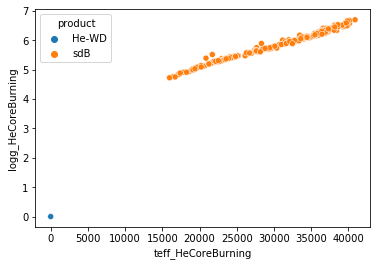

In [ ]:
sns.scatterplot('teff_HeCoreBurning', 'logg_HeCoreBurning', data=df_ce_new, hue='product')

/home/joris/Software/anaconda2/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


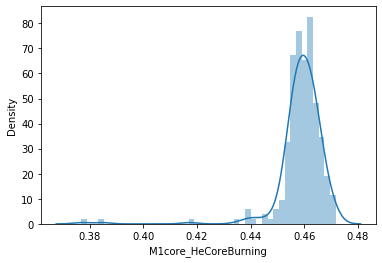

In [ ]:
sns.distplot(df_ce_new[df_ce_new['product'] == 'sdB']['M1core_HeCoreBurning'])

/home/joris/Software/anaconda2/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joris/Software/anaconda2/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


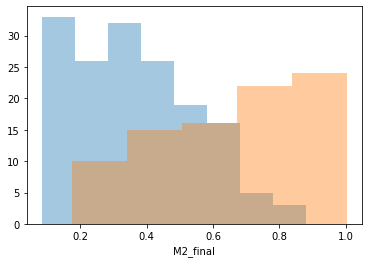

In [ ]:
sns.distplot(df_ce_new[(df_ce_new['product'] == 'sdB') & (df_ce_new['M1_init'] < 1.6)]['M2_final'], kde=False)
sns.distplot(df_ce_new[(df_ce_new['product'] == 'sdB') & (df_ce_new['M1_init'] >= 1.6)]['M2_final'], kde=False)